In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
from ripser import ripser
import scipy

import concurrent.futures
from scipy.integrate import ode
import glob
import imageio as io
from itertools import repeat

#make an image of a frame with triangles indicating cell motion
from PIL import Image
from Scripts.arrow_head_marker import *

In [2]:
def compute_angle_df(filt_df,FRAME_LIST,track_len):
    
    
    #make a histogram of velocities (displacement over some number of frames) of all cells at all times
    object = filt_df.copy()
    mags_xy = []
    track_len=FRAME_LIST[0]
    for idx in np.arange(track_len,FRAME_LIST[-1]):
        p_t1=object.particle.values[object.frame==idx-track_len]
        p_t2=object.particle.values[object.frame==idx]

        object2= object[(object["particle"].isin(p_t1)) & (object["particle"].isin(p_t2))]
        frame_t1 = object2[object2['frame']==idx-track_len]
        frame_t2 = object2[object2['frame']==idx]
        delta_x = frame_t2.x.values-frame_t1.x.values
        delta_y = frame_t2.y.values-frame_t1.y.values

        mag_xy = np.sqrt(np.square(delta_x.astype(float))+np.square(delta_y.astype(float)))
        mags_xy.append(mag_xy)

    mags_xy_data=np.concatenate(mags_xy,axis=0)
    a1,b1,c1=scipy.stats.lognorm.fit(mags_xy_data)
    rv = scipy.stats.lognorm(a1,b1,c1)
    x=np.linspace(0,0.035,100)
#     plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
#     n, bins, patches = plt.hist(mags_xy_data, 50, density=True, facecolor='g', alpha=0.75)
    #min_speed=rv.ppf(.25)
    min_speed=0

    ##NEW

    #get fast moving cells, above 25th percentile for displacement over 10 frames
    #min_speed = 0.00656070884994189 #calucated in #figures_for_paper.ipynb
    #go through frames 10 to 126 and add particles to a new data frame
    #only keep those that move fast enough
    #also calculate angle of displacement
    #keep a data frame with x,y,angle,magnitude, and frame
    new_data = pd.DataFrame(columns=['x','y','angle','mag','frame'])

    num_cells_in_frame = []
    num_cells_in_frame_all = []

    for frame_idx in FRAME_LIST:
        p_t1=filt_df.particle.values[filt_df.frame==frame_idx-track_len]
        p_t2=filt_df.particle.values[filt_df.frame==frame_idx]
        object2= filt_df[(filt_df["particle"].isin(p_t1)) & (filt_df["particle"].isin(p_t2))]
        frame_t2 = object2[object2['frame']==frame_idx]
        frame_t1 = object2[object2['frame']==frame_idx-track_len]
        delta_x = frame_t2.x.values-frame_t1.x.values
        delta_y = frame_t2.y.values-frame_t1.y.values
        angle_xy = np.arctan2(delta_y,delta_x)
        deg_xy = np.mod(np.degrees(angle_xy),360)
        mag_xy = np.sqrt(np.square(delta_x)+np.square(delta_y))
        x = frame_t2.x.values
        y = frame_t2.y.values
        count=0
        all_count = 0
        for idx,val in enumerate(x):
            all_count +=1
            if mag_xy[idx]>min_speed:
                count+=1
                df1 = pd.DataFrame({'x':[x[idx]],'y':[y[idx]],'angle':[deg_xy[idx]],'mag':[mag_xy[idx]],'frame':[frame_idx]})
                #print(df1)
                new_data=pd.concat([new_data,df1],ignore_index=True,axis=0)
                #sc=ax.scatter(x[idx],y[idx],c=deg_xy[idx],vmin=0,vmax=360,cmap='hsv',marker=marker, s=(markersize*scale)**2)
        num_cells_in_frame.append(count)
        num_cells_in_frame_all.append(len(p_t2))
        
    return new_data

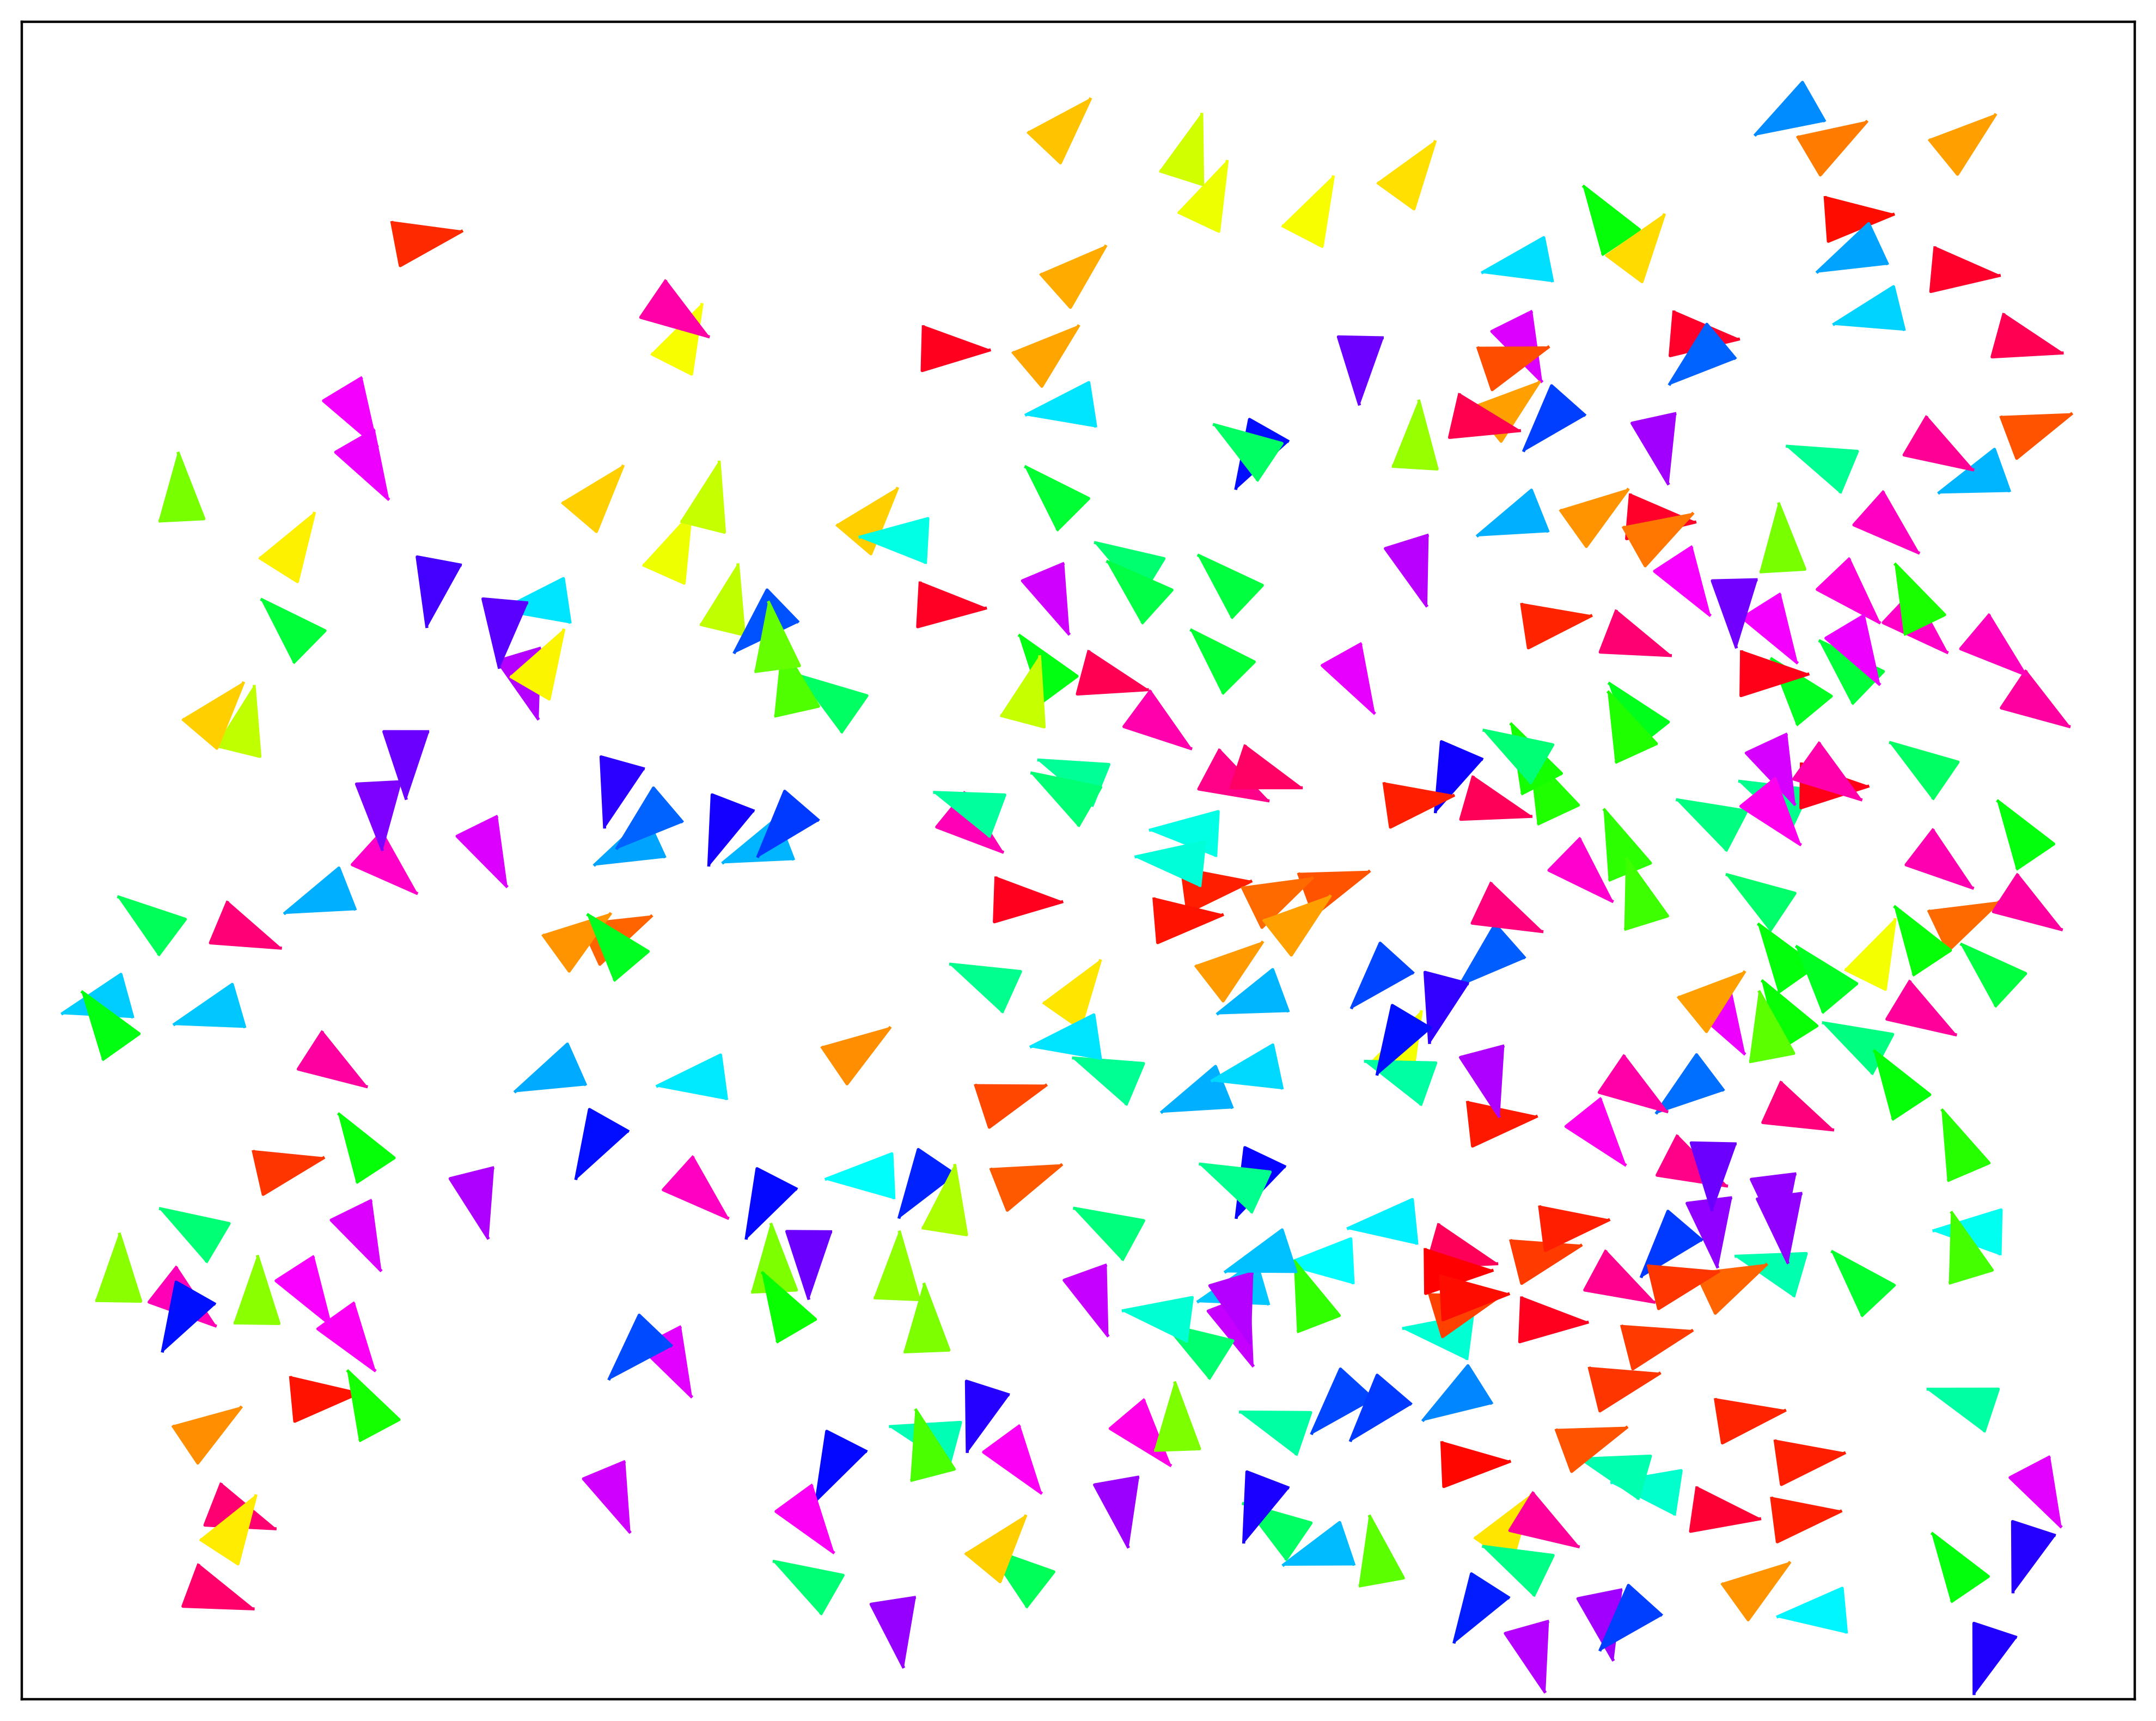

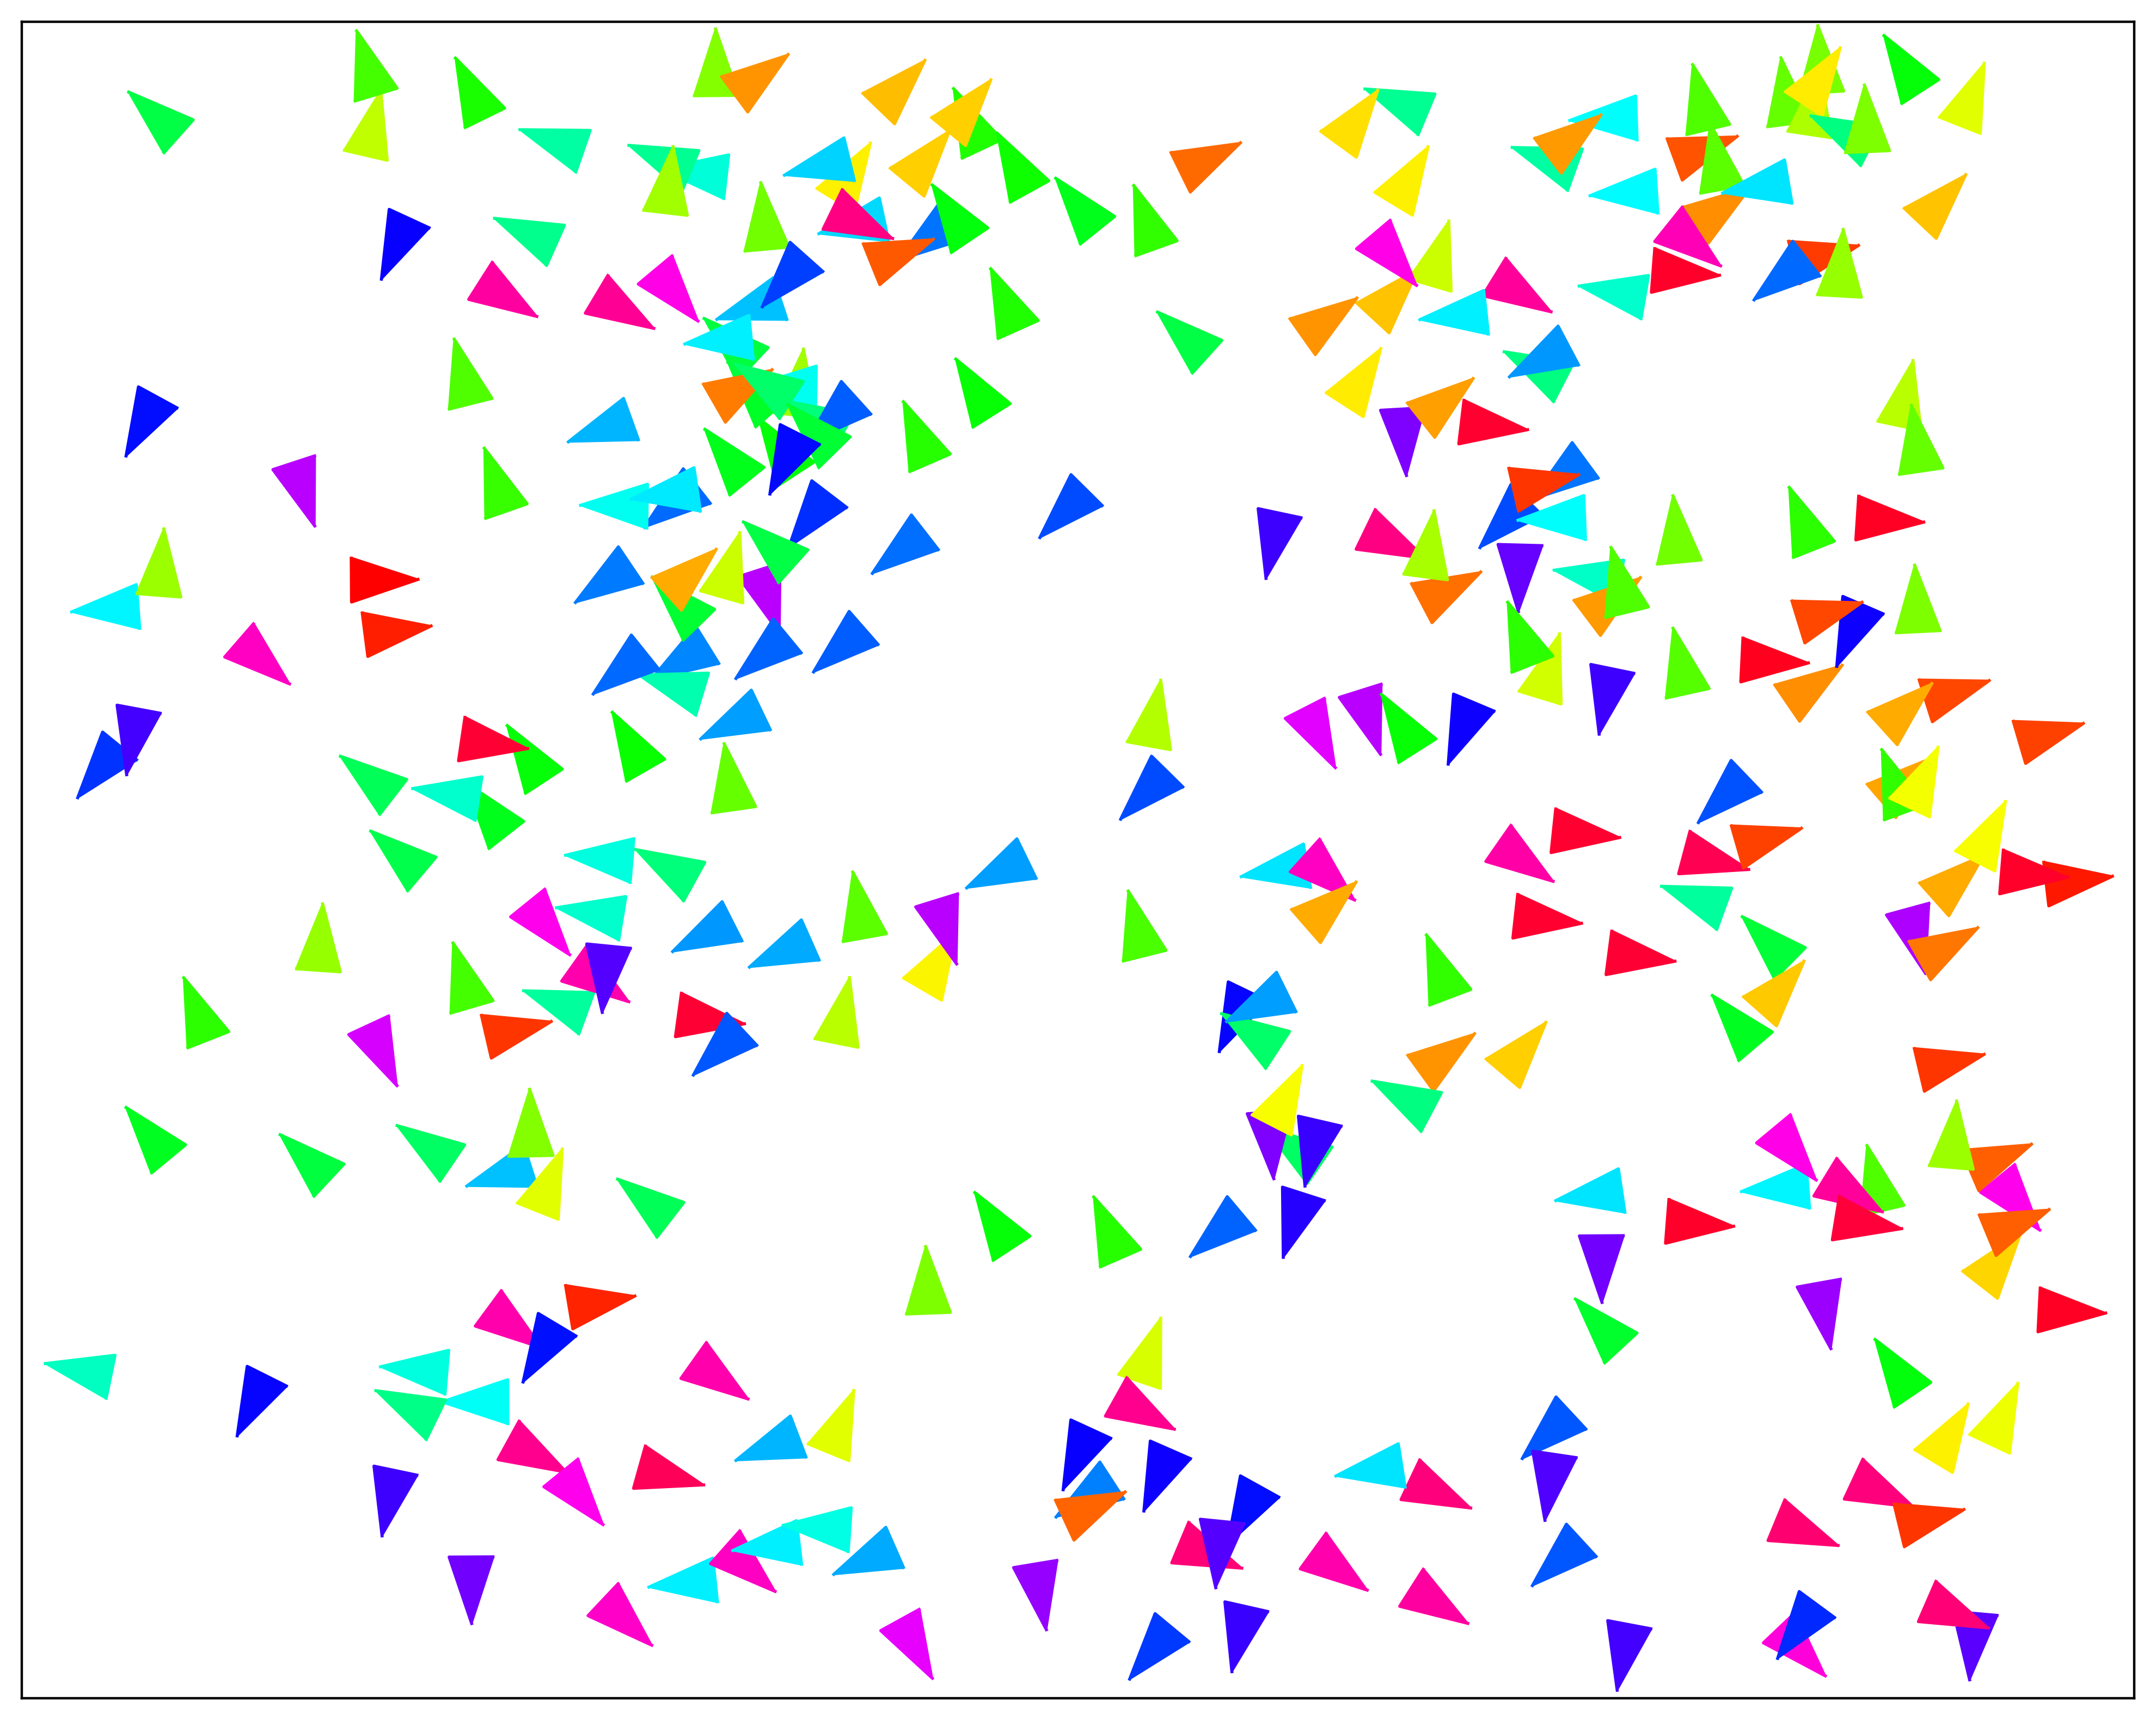

In [4]:
#VANILLA CROCKER
#Which DataFrame columns to use as dimensions
track_len=13

#List of frame values to use, must be aligned for direct comparison
FRAME_LIST = range(13,118,1) #starts at 10 because of angle computation
#compute the data for the crocker plot
frame_idx=100

stage_idc = [40] #[37, 38, 39, 40, 41, 42]

for stage_idx in stage_idc:
    
    # Get true data frame:
    true_PATH = './scratch_assay_data/subsampled_data/stage_'+str(stage_idx)+'_subsampled.pkl'
    new_data = pd.read_pickle(true_PATH)
    new_data.x = new_data.x/25
    new_data.y = new_data.y/25
    new_data.vy = new_data.vx/25
    new_data.vy = new_data.vy/25
    
    fig=plt.figure(figsize=(10,8),dpi=400)
    ax = fig.add_subplot(111)
    x = new_data[new_data['frame']==frame_idx].x.values 
    y = new_data[new_data['frame']==frame_idx].y.values
    deg_xy = new_data[new_data['frame']==frame_idx].angle.values
    for idx,val in enumerate(x):
        marker, scale = gen_arrow_head_marker(deg_xy[idx])
        markersize=50
        sc=ax.scatter(x[idx],y[idx],c=deg_xy[idx],vmin=0,vmax=360,cmap='hsv',marker=marker, s=(markersize*scale)**2)
#     cbar = plt.colorbar(sc)
#     for t in cbar.ax.get_yticklabels():
#         t.set_fontsize(30)
    ax.tick_params(left = False, right = False, labelleft = False,
                   labelbottom = False, bottom = False)
    plt.tight_layout()
    plt.savefig('./Results/stage_'+str(stage_idx)+'/stage_'+str(stage_idx)+'_true_lastFrame.pdf',bbox_inches='tight')
    
    # Get ABC results:
    ABC_path = './Results/stage_'+str(stage_idx)+'/ABC_df_angles_p01_angles.pkl'
    new_data = pd.read_pickle(ABC_path)
    new_data.x = new_data.x/25
    new_data.y = new_data.y/25
    new_data.vy = new_data.vx/25
    new_data.vy = new_data.vy/25
    # new_data = compute_angle_df(ABC_df,FRAME_LIST,track_len)
    
    fig=plt.figure(figsize=(10,8),dpi=400)
    ax = fig.add_subplot(111)
    x = new_data[new_data['frame']==frame_idx].x.values 
    y = new_data[new_data['frame']==frame_idx].y.values
    deg_xy = new_data[new_data['frame']==frame_idx].angle.values
    for idx,val in enumerate(x):
        marker, scale = gen_arrow_head_marker(deg_xy[idx])
        markersize=50
        sc=ax.scatter(x[idx],y[idx],c=deg_xy[idx],vmin=0,vmax=360,cmap='hsv',marker=marker, s=(markersize*scale)**2)
#     cbar = plt.colorbar(sc)
#     for t in cbar.ax.get_yticklabels():
#         t.set_fontsize(20)
    ax.tick_params(left = False, right = False, labelleft = False,
                   labelbottom = False, bottom = False)
    plt.tight_layout()
    plt.savefig('./Results/stage_'+str(stage_idx)+'/stage_'+str(stage_idx)+'_ABCmedian_lastFrame.pdf',bbox_inches='tight')